In [ ]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np


In [7]:

# Dataset Class 
class BrainTumorDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.samples = []
        image_files = [f for f in sorted(os.listdir(image_dir)) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        mask_files = [f for f in sorted(os.listdir(mask_dir)) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        mask_bases = {os.path.splitext(f)[0] for f in mask_files}
        for img_file in image_files:
            base_name = os.path.splitext(img_file)[0]
            if base_name in mask_bases:
                mask_match = [f for f in mask_files if os.path.splitext(f)[0] == base_name]
                if mask_match:
                    self.samples.append((img_file, mask_match[0]))
                    
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, mask_name = self.samples[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)
        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        mask = (mask > 0).float()
        return image, mask, img_name  # returning img_name for visualization
    

In [ ]:
# Double Convolution block for simpler architecture
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv(x)


# Multi-Scale Block with fixed output channels
class MultiScaleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MultiScaleConv, self).__init__()
        # Make sure out_channels is divisible by 3
        out_per_conv = out_channels // 3
        # Adjust if not perfectly divisible
        self.out_ch1 = out_per_conv
        self.out_ch2 = out_per_conv
        self.out_ch3 = out_channels - (2 * out_per_conv)  # To Ensure total is exactly out_channels
        
        self.conv3 = nn.Conv2d(in_channels, self.out_ch1, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels, self.out_ch2, kernel_size=5, padding=2)
        self.conv7 = nn.Conv2d(in_channels, self.out_ch3, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x3 = self.conv3(x)
        x5 = self.conv5(x)
        x7 = self.conv7(x)
        x_cat = torch.cat([x3, x5, x7], dim=1)
        return self.relu(self.bn(x_cat))


In [10]:
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        # If F_int would be zero, adjust it
        if F_int < 1:
            F_int = 1
            
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi



In [14]:
# U-Net with MultiScale convolutions and Attention
class MSAttentionUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512]):
        super(MSAttentionUNet, self).__init__()
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Down path (encoder)
        self.encoder = nn.ModuleList()
        in_channels_encoder = in_channels
        for feature in features:
            self.encoder.append(DoubleConv(in_channels_encoder, feature))
            in_channels_encoder = feature
            
        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        
        # Up path (decoder)
        self.upconvs = nn.ModuleList()
        self.attention_blocks = nn.ModuleList()
        self.decoder = nn.ModuleList()
        
        for feature in reversed(features):
            # Upsampling
            self.upconvs.append(
                nn.ConvTranspose2d(feature * 2, feature, kernel_size=2, stride=2)
            )
            # Attention gate
            self.attention_blocks.append(
                AttentionBlock(F_g=feature, F_l=feature, F_int=feature // 4)
            )
            # Decoder block
            self.decoder.append(
                DoubleConv(feature * 2, feature)
            )
            
        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
    def forward(self, x):
        # Store encoder outputs for skip connections
        skip_connections = []
        
        # Encoder path
        for enc in self.encoder:
            x = enc(x)
            skip_connections.append(x)
            x = self.pool(x)
        
        # Bottleneck
        x = self.bottleneck(x)
        
        # Reverse skip connections for upsampling path
        skip_connections = skip_connections[::-1]
        
        # Decoder path
        for idx in range(len(self.decoder)):
            x = self.upconvs[idx](x)
            skip = skip_connections[idx]
            
            # Apply attention mechanism
            attn_skip = self.attention_blocks[idx](x, skip)
            
            # Concatenate
            x = torch.cat((attn_skip, x), dim=1)
            
            # Decode
            x = self.decoder[idx](x)
        
        # Final convolution
        return self.final_conv(x)


# Dice score for evaluation
def dice_score(pred, target):
    smooth = 1e-5
    pred = torch.sigmoid(pred) > 0.5
    pred = pred.float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

# Accuracy calculation
def calculate_accuracy(outputs, masks):
    outputs = torch.sigmoid(outputs)
    predicted = (outputs > 0.5).float()
    correct = (predicted == masks).float().sum()
    return correct / masks.numel()

In [ ]:

# ------------------ Training Setup ---------------------
BATCH_SIZE = 64
LR = 1e-4
EPOCHS = 20
IMAGE_SIZE = 256
transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])

dataset = BrainTumorDataset(
    image_dir="./brain_tumor/images",
    mask_dir="./brain_tumor/masks",
    transform=transform
)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MSAttentionUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.BCEWithLogitsLoss()


In [11]:
for epoch in range(EPOCHS):
    model.train()
    total_loss, total_acc, total_dice = 0, 0, 0
    
    for img, mask, _ in train_loader:
        img, mask = img.to(device), mask.to(device)
        
        # Forward pass
        out = model(img)
        
        # Calculate loss
        loss = criterion(out, mask)
        
        # Calculate metrics
        acc = calculate_accuracy(out, mask)
        dice = dice_score(out, mask)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate metrics
        total_loss += loss.item()
        total_acc += acc.item()
        total_dice += dice.item()
    
    # Print training metrics
    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    avg_dice = total_dice / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_loss:.4f} | Acc: {avg_acc:.4f} | Dice: {avg_dice:.4f}")
    
    # Validation
    if (epoch + 1) % 5 == 0 or epoch == EPOCHS - 1:  # Every 5 epochs and final epoch
        model.eval()
        val_loss, val_acc, val_dice = 0, 0, 0
        
        with torch.no_grad():
            for img, mask, _ in val_loader:
                img, mask = img.to(device), mask.to(device)
                out = model(img)
                
                loss = criterion(out, mask)
                acc = calculate_accuracy(out, mask)
                dice = dice_score(out, mask)
                
                val_loss += loss.item()
                val_acc += acc.item()
                val_dice += dice.item()
        
        # Print validation metrics
        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc = val_acc / len(val_loader)
        avg_val_dice = val_dice / len(val_loader)
        print(f"Validation | Loss: {avg_val_loss:.4f} | Acc: {avg_val_acc:.4f} | Dice: {avg_val_dice:.4f}")


Epoch 1/20 | Train Loss: 0.5652 | Acc: 0.8296 | Dice: 0.3411
Epoch 2/20 | Train Loss: 0.4372 | Acc: 0.9450 | Dice: 0.5715
Epoch 3/20 | Train Loss: 0.3681 | Acc: 0.9562 | Dice: 0.6144
Epoch 4/20 | Train Loss: 0.3356 | Acc: 0.9602 | Dice: 0.6465
Epoch 5/20 | Train Loss: 0.3166 | Acc: 0.9633 | Dice: 0.6832
Validation | Loss: 0.3284 | Acc: 0.9641 | Dice: 0.5290
Epoch 6/20 | Train Loss: 0.3000 | Acc: 0.9681 | Dice: 0.7350
Epoch 7/20 | Train Loss: 0.2894 | Acc: 0.9700 | Dice: 0.7583
Epoch 8/20 | Train Loss: 0.2766 | Acc: 0.9744 | Dice: 0.7977
Epoch 9/20 | Train Loss: 0.2695 | Acc: 0.9749 | Dice: 0.8064
Epoch 10/20 | Train Loss: 0.2601 | Acc: 0.9777 | Dice: 0.8257
Validation | Loss: 0.2617 | Acc: 0.9753 | Dice: 0.7273
Epoch 11/20 | Train Loss: 0.2501 | Acc: 0.9804 | Dice: 0.8500
Epoch 12/20 | Train Loss: 0.2424 | Acc: 0.9823 | Dice: 0.8641
Epoch 13/20 | Train Loss: 0.2361 | Acc: 0.9833 | Dice: 0.8727
Epoch 14/20 | Train Loss: 0.2307 | Acc: 0.9832 | Dice: 0.8743
Epoch 15/20 | Train Loss: 0.225

In [12]:
# Save model
torch.save(model.state_dict(), "ms_attention_unet.pth")
print("✅ Model saved as ms_attention_unet.pth")

✅ Model saved as ms_attention_unet.pth


In [19]:
# ------------------ Loading Saved Model ---------------------
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize a new model instance
loaded_model = MSAttentionUNet().to(device)

# Load the saved weights
try:
    loaded_model.load_state_dict(torch.load("ms_attention_unet.pth", map_location=device))
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"❌ Failed to load model: {e}")

# Set model to evaluation mode
loaded_model.eval()

✅ Model loaded successfully!


MSAttentionUNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder): ModuleList(
    (0): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2

✅ Predicted mask saved as predicted_mask.png


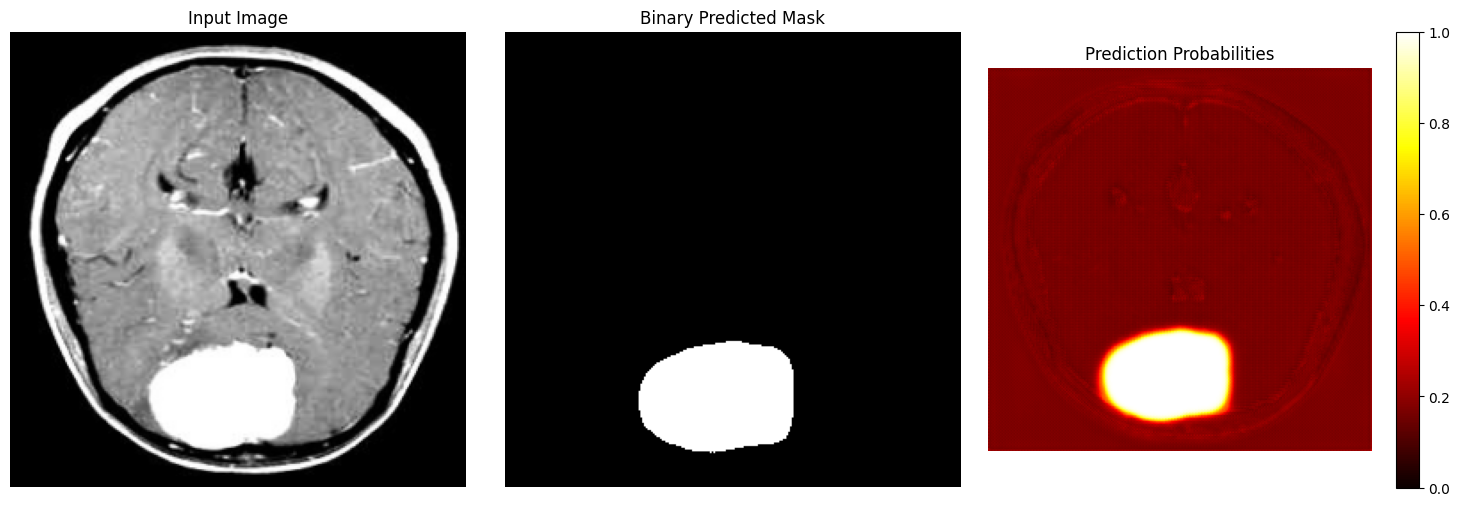

In [20]:
# ------------------ Single Image Prediction ---------------------

# Path to the test image (Change this path to your specific image)
TEST_IMAGE_PATH = "./brain_tumor/images/y4.jpg"  # Adjust this path as needed

# Output path to save predicted mask
OUTPUT_MASK_PATH = "predicted_mask.png"

# Load and preprocess the image
image = Image.open(TEST_IMAGE_PATH).convert('L')
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# Run inference
with torch.no_grad():
    output = loaded_model(input_tensor)
    pred_probs = torch.sigmoid(output)
    pred_mask = (pred_probs > 0.5).float()

# Convert tensor mask to numpy
mask_np = pred_mask.squeeze().cpu().numpy()
probs_np = pred_probs.squeeze().cpu().numpy()
image_np = input_tensor.squeeze().cpu().numpy()


# Save the mask
mask_img = Image.fromarray((mask_np * 255).astype(np.uint8))
mask_img.save(OUTPUT_MASK_PATH)
print(f"✅ Predicted mask saved as {OUTPUT_MASK_PATH}")

# Visualization
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_np, cmap='gray')
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mask_np, cmap='gray')
plt.title("Binary Predicted Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(probs_np, cmap='hot', vmin=0, vmax=1)
plt.title("Prediction Probabilities")
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()

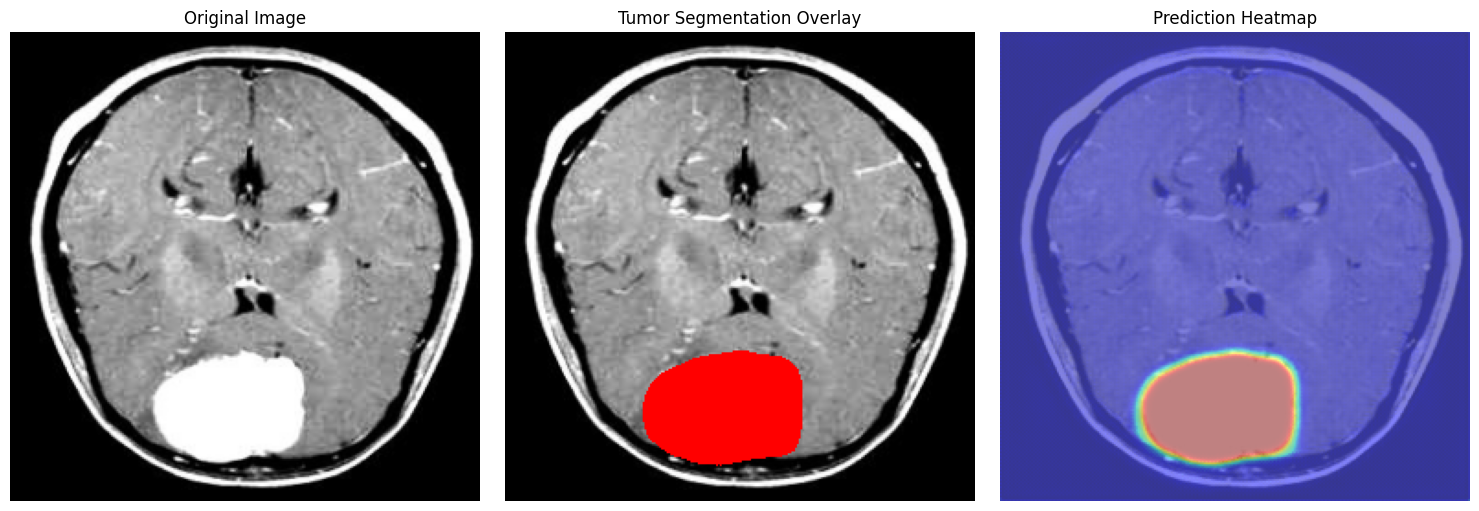

In [ ]:


# Create colored overlay
def create_overlay(image, prediction):
    # Create RGB image from grayscale
    rgb_img = np.stack([image]*3, axis=-1)
    if rgb_img.max() > 1.0:
        rgb_img = rgb_img / 255.0
        
    # Create overlay with tumor region in red
    overlay = rgb_img.copy()
    overlay[prediction > 0.5, 0] = 1.0  # Red channel
    overlay[prediction > 0.5, 1] = 0.0  # Green channel
    overlay[prediction > 0.5, 2] = 0.0  # Blue channel
    
    # Return the overlay
    return overlay

# Create and display overlay
overlay_img = create_overlay(image_np, mask_np)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(image_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(overlay_img)
plt.title("Tumor Segmentation Overlay")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(probs_np, cmap='jet', alpha=0.7)
plt.imshow(image_np, cmap='gray', alpha=0.3)
plt.title("Prediction Heatmap")
plt.axis('off')

plt.tight_layout()
plt.show()